- 참고 블로그 
- https://jkisaaclee.kro.kr/keras/facenet/deep%20learning/computer%20vision/2019/10/01/how_to_develop_a_face_recognition_system_using_facenet_in_keras_ko/
- **미리 사전학습된 FaceNet model 받아두기**
- https://drive.google.com/drive/folders/1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install mtcnn

     |████████████████████████████████| 2.3 MB 4.3 MB/s 


### MTCNN 사용해서 Face Detection

In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [ ]:
# 주어진 사진에서 하나의 얼굴 추출
def extract_face(filename, required_size=(160, 160), save=False):
    print(filename)
    # 파일에서 이미지 불러오기
    image = Image.open(filename)
    # RGB로 변환, 필요시
    image = image.convert('RGB')
    # 배열로 변환
    pixels = np.asarray(image)
    # 감지기 생성, 기본 가중치 이용
    detector = MTCNN()
    # 이미지에서 얼굴 감지
    results = detector.detect_faces(pixels)
    # 첫 번째 얼굴에서 경계 상자 추출
    # detect_faces의 결과물 : box, cofidence, keypoints(left_eye, right_eye, nose, mouth_left, mouth_right)
    # 사진 크기가 너무 작아서 detect가 안되는 경우가 있음 -> 우선 그런 영상들을 제외하고 진행
    if len(results)==0:
        return np.asarray([])
    x1, y1, width, height = results[0]['box']
    # 버그 수정
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # 얼굴 추출
    face = pixels[y1:y2, x1:x2]
    # 모델 사이즈로 픽셀 재조정
    # Image.fromarray() : 배열 객체를 입력으로 받아 배열 객체에서 만든 이미지 객체를 반환
    image = Image.fromarray(face)
    image = image.resize(required_size)
    # face data 저장
    if save == True:
        face_path = filename.split('/') #['drive','MyDrive','team_project','dataset','female','0000.jpg']
        jpg = face_path[-1].split('.')[0]+'.jpg'
        face_path[-1] = jpg
        face_path[-2] = face_path[-2]+'_face'
        face_path = os.path.join(*face_path)
        image.save(face_path)
    face_array = np.asarray(image)
    return face_array

In [ ]:
# 디렉토리 안의 모든 이미지를 불러오고 이미지에서 얼굴 추출
def load_faces(directory):
    faces = list()
    # 얼굴이 아예 검출되지 않은 경우, filename 확인
    no_face = list()
    # 파일 열거
    for filename in sorted(os.listdir(directory)):
        # 경로
        path = directory + '/' + filename
        # 얼굴 추출
        face = extract_face(path)
        # 얼굴 사진 따로 저장해서 확인하고 싶으면 save = True로 해서 돌리기
        # face = extract_face(path,(160,160),True)
        if len(face) == 0:
            no_face.append(filename)
        # 저장
        else:
            faces.append(face)
    # extrac_face할때, 얼굴이 검출되지 않은 경우 []을 리턴했기 때문에 제거하는 과정 
    faces = list(filter(lambda x: len(x)>0, faces))
    return faces, no_face

In [ ]:
# 검출된 얼굴 데이터를 array로 저장 -> 나중에 FaceNet이 이 파일 load해서 입력으로 쓸 수 있도록
path = './drive/MyDrive/team_project/dataset/'
gender = ['female', 'male']
for g in gender:
    faces, no_face = load_faces(path+g)
    print('검출되지 않은 image 파일 :', no_face)
    print('{} dataset에서 검출된 face 개수 : {}'.format(g, len(faces)))
    faces = np.asarray(faces)
    np.savez_compressed('./drive/MyDrive/team_project/npz/'+g+'_faces.npz',faces)

### FaceNet을 사용해서 Face Embedding

In [6]:
# 입력으로 들어온 model과 face data로 embedding 구하기
# 각 성별 전체 얼굴 데이터 모두 embedding으로 변환하여 반환
def get_embeddings(model, faces_data):
    embeddings = list()
    for face_pixels in faces_data:
        # 픽셀 값의 척도
        face_pixels = face_pixels.astype('int32')
        # 채널 간 픽셀값 표준화(전역에 걸쳐)
        mean, std = face_pixels.mean(), face_pixels.std()
        face_pixels = (face_pixels - mean) / std
        samples = np.expand_dims(face_pixels, axis=0)
        # 임베딩을 갖기 위한 예측 생성
        embedding = model.predict(samples)
        embeddings.append(embedding[0])
    embeddings = np.asarray(embeddings)
    return embeddings

In [7]:
# Warning 뜨는데 사실 아직 안 찾아봤어요... 

from keras.models import load_model

# facenet 모델 불러오기
model = load_model(filepath='./drive/MyDrive/team_project/model/facenet_keras.h5')
print(model.inputs)
# 얼굴 데이터 불러오기
female_data = np.load('./drive/MyDrive/team_project/npz/female_faces.npz')['arr_0']
# embedding 받아오기
female_embeddings = get_embeddings(model,female_data)
print(female_embeddings.shape)

'''
male_data = np.load('./drive/MyDrive/team_project/dataset/male_faces.npz')['arr_0']
male_embeddings = get_embeddings(model,male_data)
print(male_embeddings.shape)
'''

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
(615, 128)


"\nmale_data = np.load('./drive/MyDrive/team_project/dataset/male_faces.npz')['arr_0']\nmale_embeddings = get_embeddings(model,male_data)\nprint(male_embeddings.shape)\n"

# tSNE 시각화 함수

In [8]:
def tSNE(arr, y_pred):
  model = TSNE(learning_rate=200)
  transformed = model.fit_transform(arr)

  xs = transformed[:,0]
  ys = transformed[:,1]
  plt.scatter(xs, ys, c=y_pred, cmap='rainbow')
  plt.show()

### 구한 Embedding을 기반으로 Clustering
- 현재 K-means Clustering 사용하고 있음
- 이후, 다른 clustering 알고리즘 사용해서 가장 성능 좋은 것을 선택하면 될 것 같다.

In [ ]:
# cluster 개수 지정
n = 10
# k-means++ : 가지고 있는 데이터 포인트 중에서 무작위로 1개를 선택하여 그 녀석을 첫번째 중심점으로 지정
# 근데 사실 init = 'k-means++'라고 안해줘도 기본값으로 되어있다고 함 
kmeans = KMeans(init="k-means++", n_clusters=n, random_state=6)
# female으로 할지 male로 돌릴지 정해주기
kmeans.fit(female_embeddings)
y_pred = kmeans.labels_

tSNE(female_embeddings, y_pred)

def viz_img(y_pred, n=10):
    fig = plt.figure(figsize=(50,50))
    box_index = 1
    for cluster in range(n):
        result = np.where(y_pred == cluster)
        for i in np.random.choice(result[0].tolist(), n, replace=False):
            ax = fig.add_subplot(n, n, box_index)
            plt.imshow(female_data[i])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            box_index += 1
    plt.show()
    
y_pred
#viz_img(y_pred, n)

# 고정 클러스터링 저장

In [ ]:
# 데이터 크기에 맞는 빈 DataFrame 생성

k_lb = pd.DataFrame(index = [i for i in range(len(female_embeddings))], columns=[5,4,3])
k_lb.fillna(0)

In [ ]:
# k-Means clustering 반복 수행
# n에 따라 클러스터링 개수 변경 가능
# 우선은 간단히 해보려고 순차적으로 5, 4, 3 이런 식으로 클러스터링 했으나, 10, 6, 2 이런 식으로도 가능.

def kmeans_clustering(idx, n, rs=42):
  if n<=n-3:
    return
  kmeans = KMeans(n_clusters = n, random_state=42)
  kmeans.fit(female_embeddings[idx])
  y_pred = list(kmeans.labels_)

  for i in list(set(y_pred)):
    kmeans_clustering(idx[np.where(y_pred==i)[0]],n-1,rs)

  for i in idx:
    k_lb[n].iloc[i]=y_pred.pop(0)
  
  
  
kmeans_clustering(np.array([i for i in range(len(female_embeddings))]),5,42)

k_lb

# 단일 선택

0


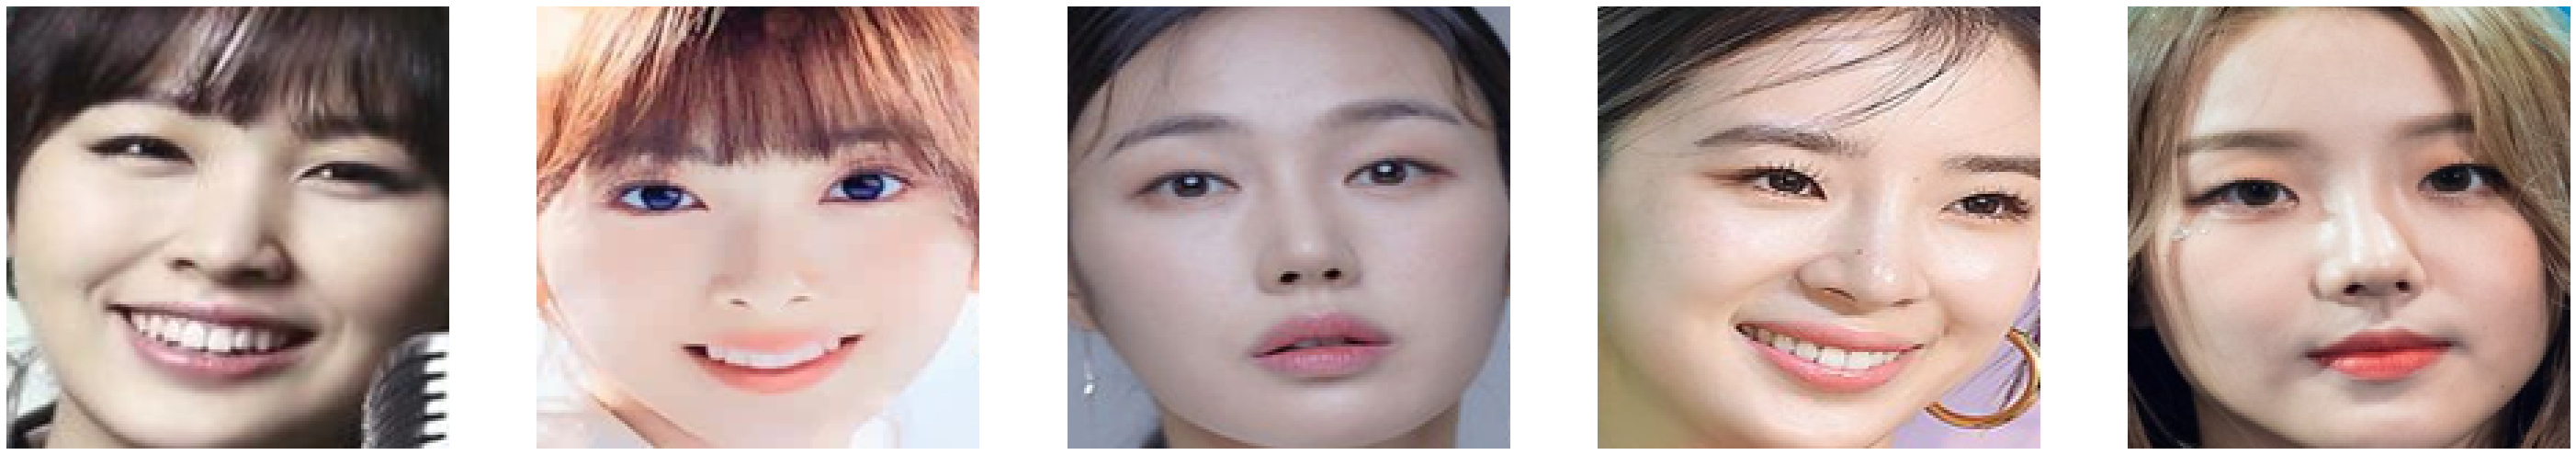

가장 선호하는 외모를 선택해 주세요. : 2


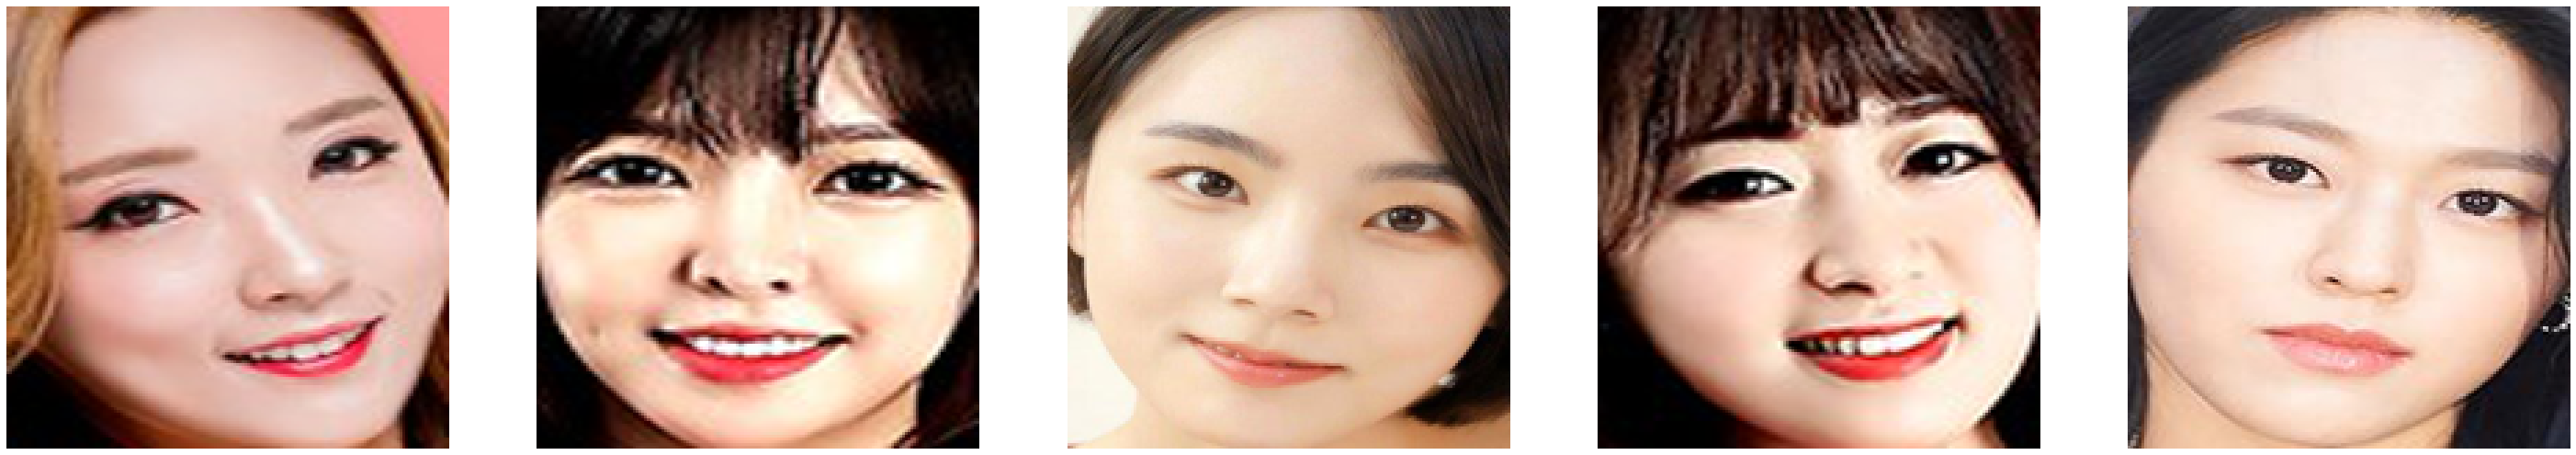

가장 선호하는 외모를 선택해 주세요. : 2


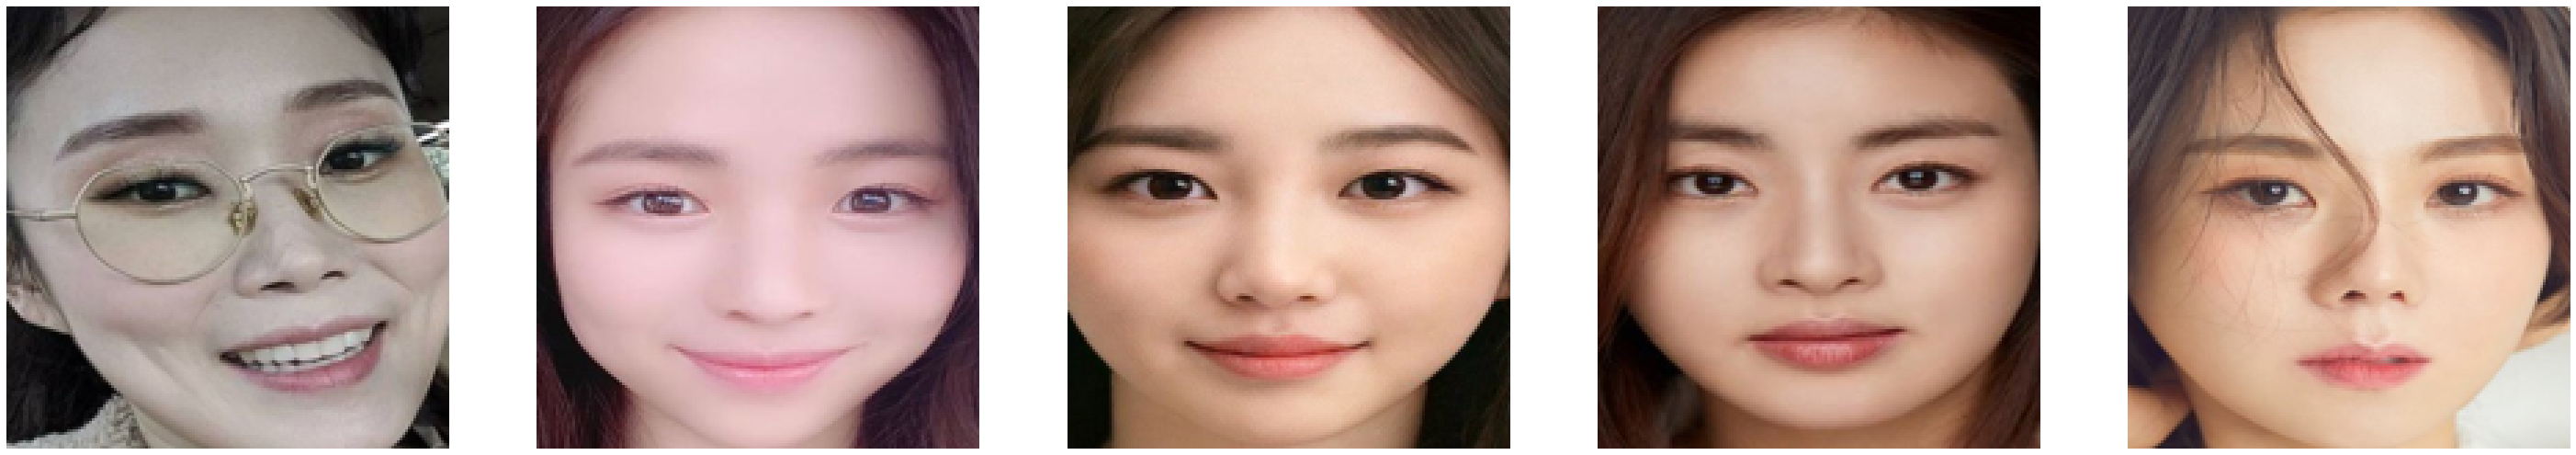

가장 선호하는 외모를 선택해 주세요. : 2


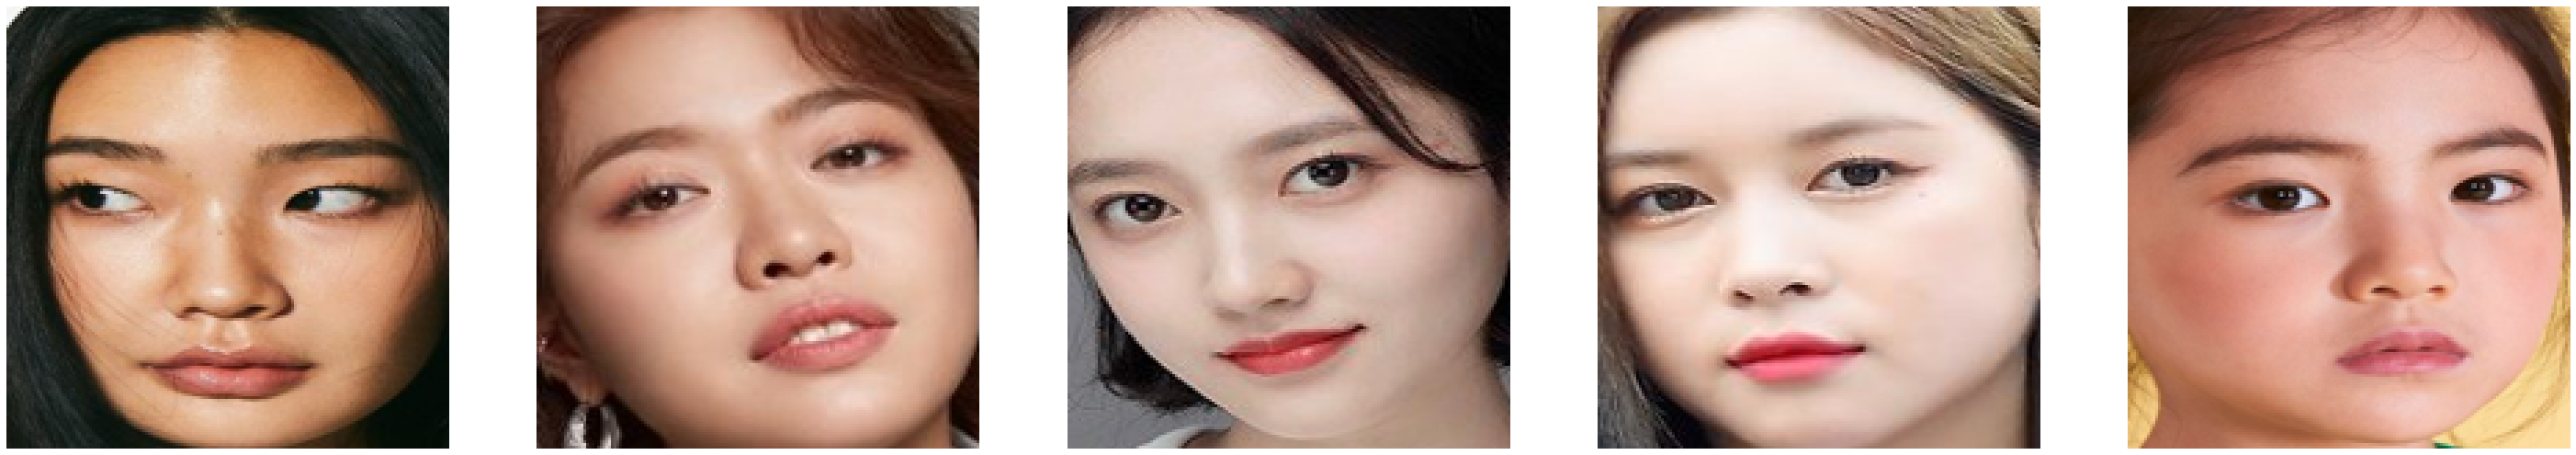

가장 선호하는 외모를 선택해 주세요. : 2


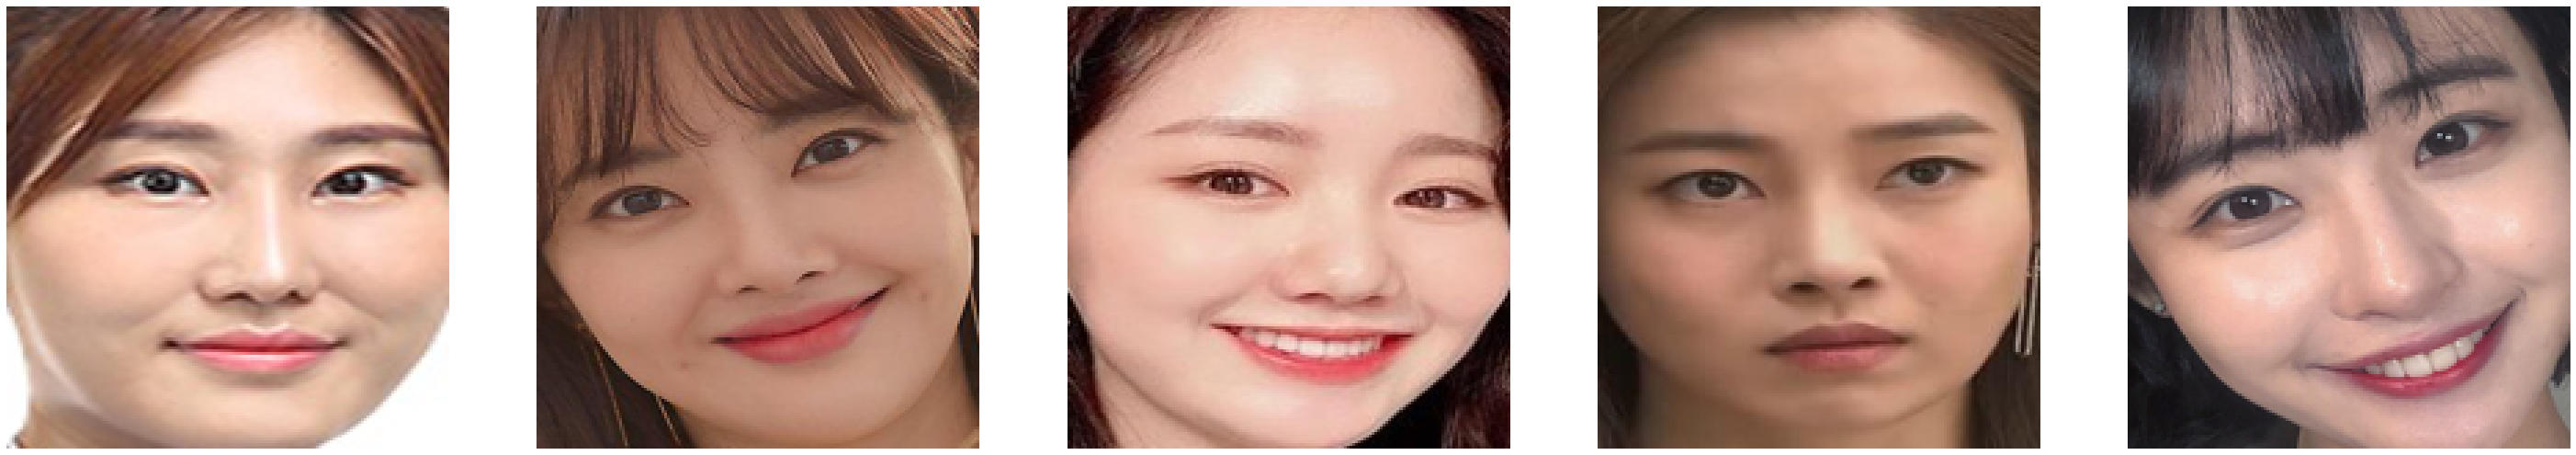

가장 선호하는 외모를 선택해 주세요. : 2
1


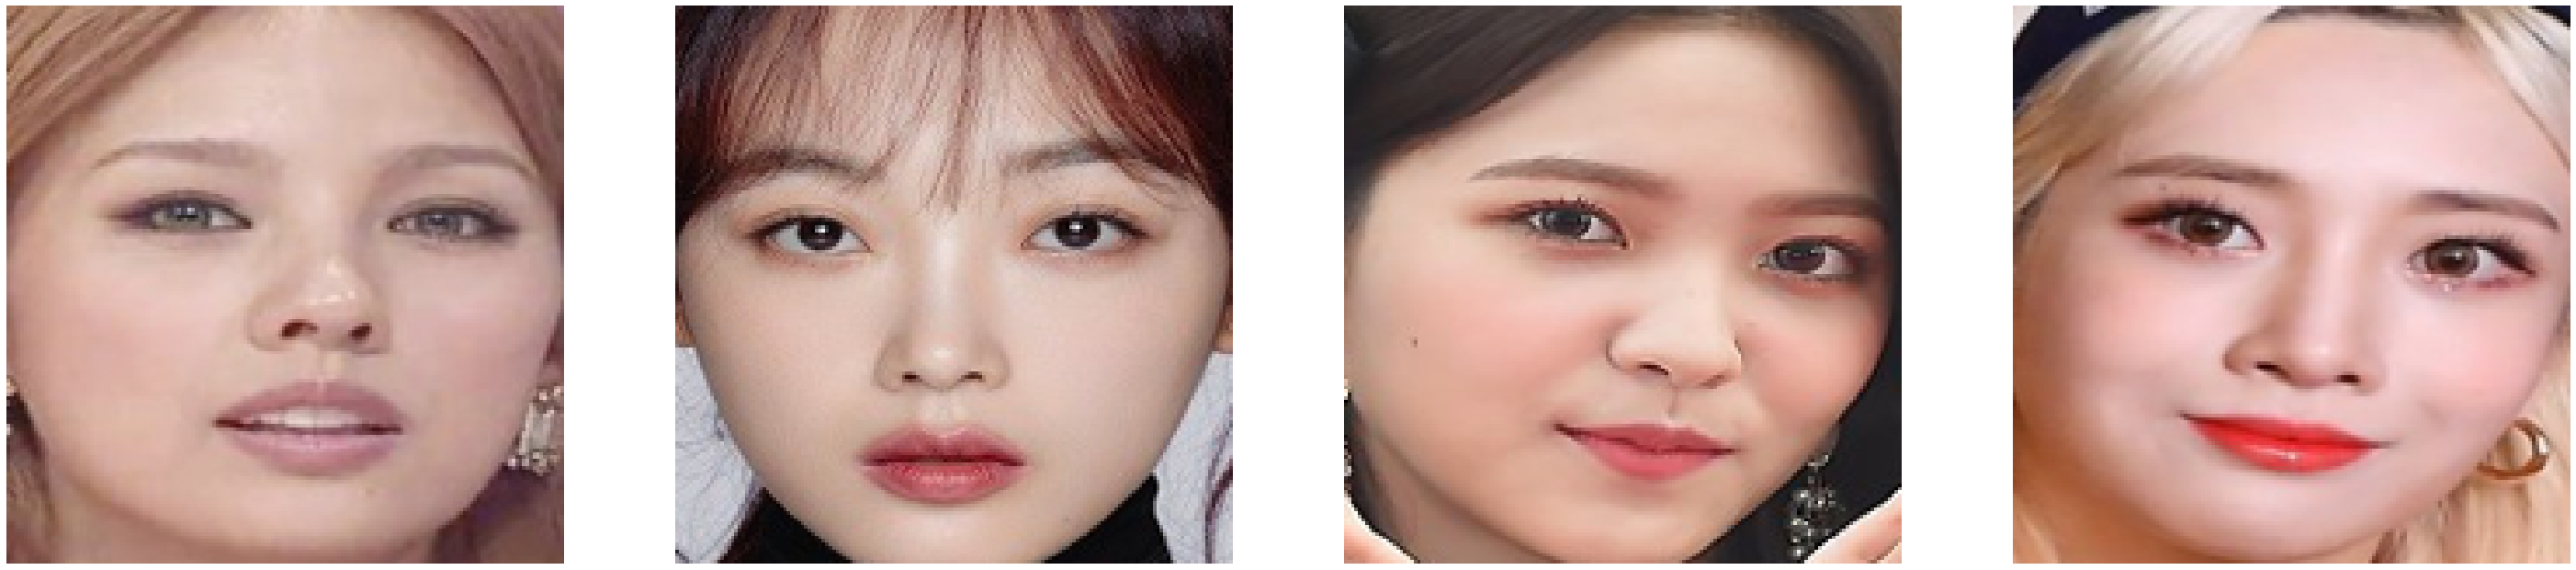

가장 선호하는 외모를 선택해 주세요. : 2


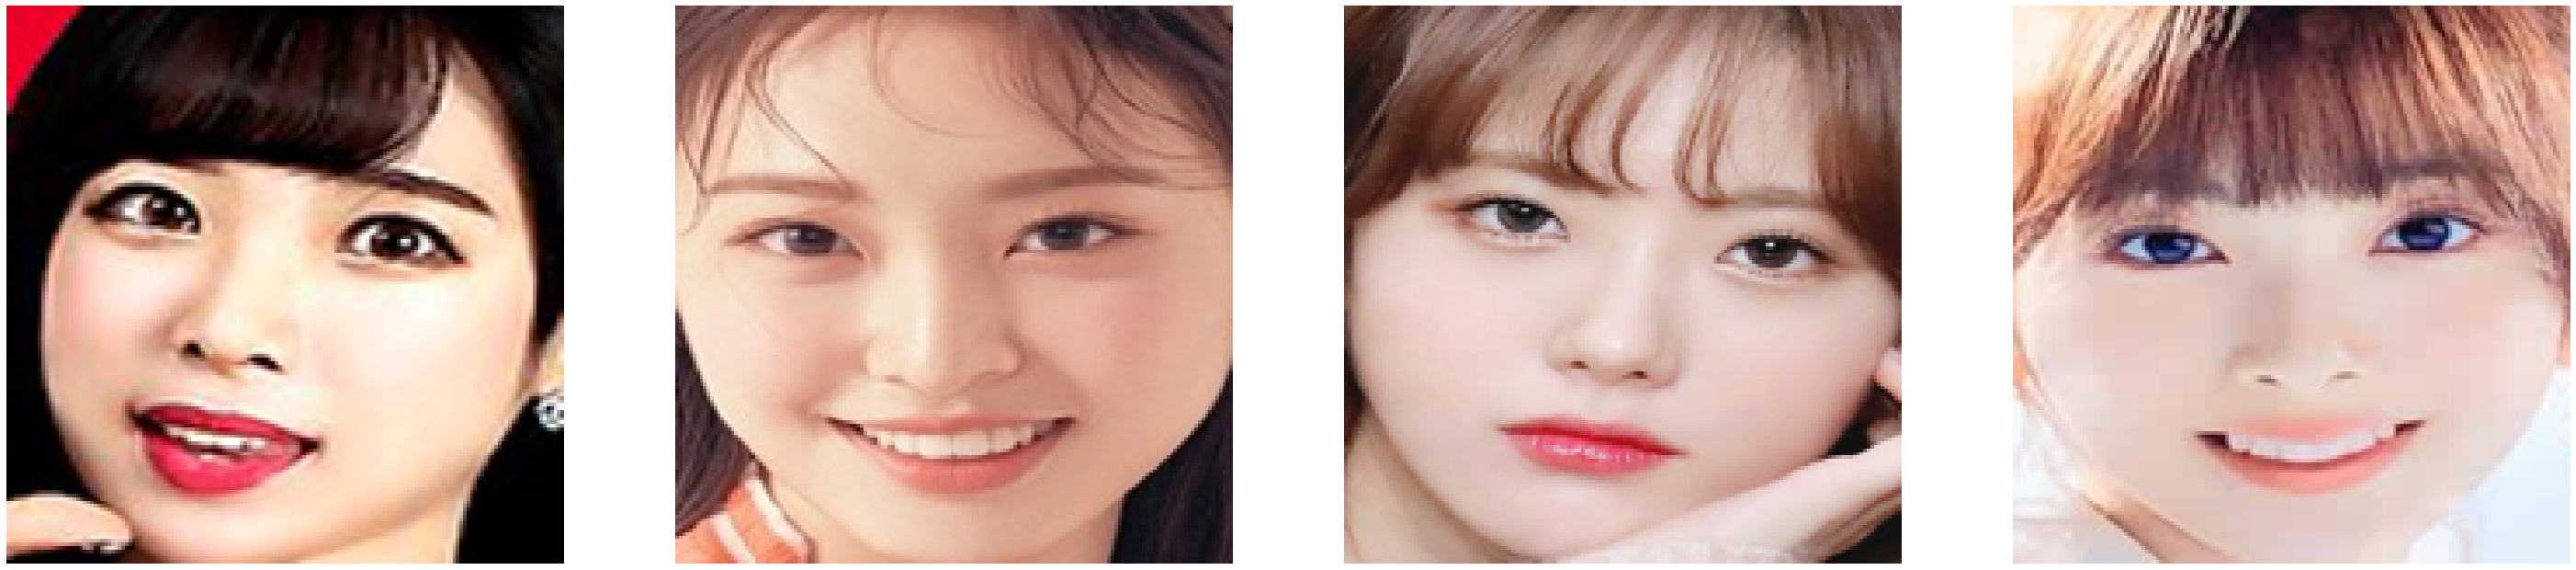

가장 선호하는 외모를 선택해 주세요. : 2


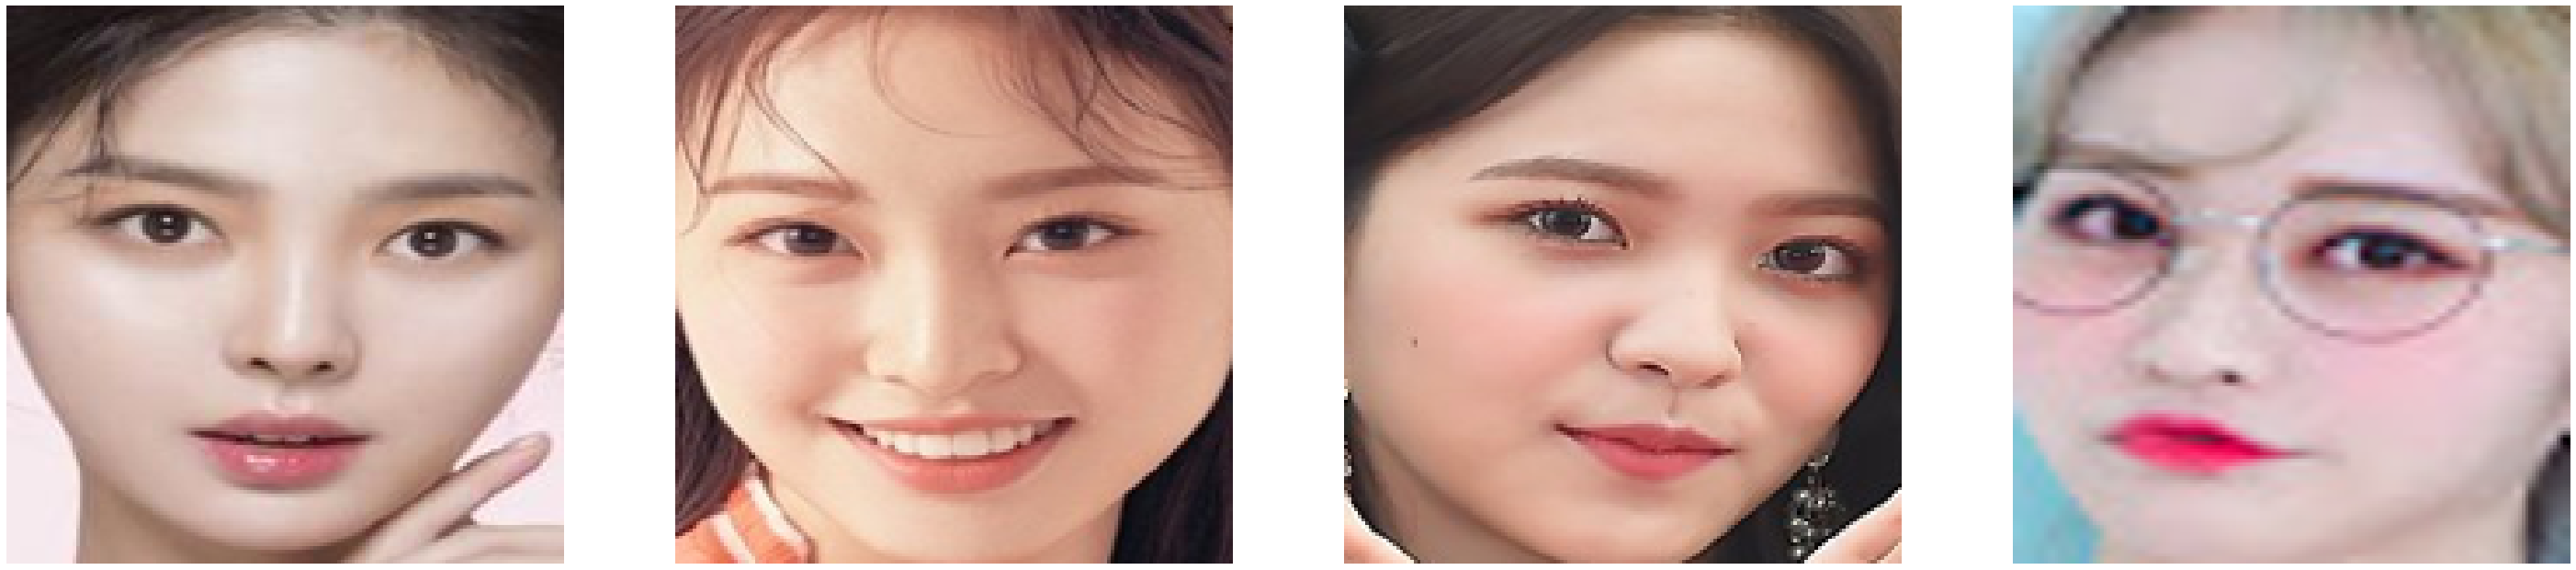

가장 선호하는 외모를 선택해 주세요. : 2


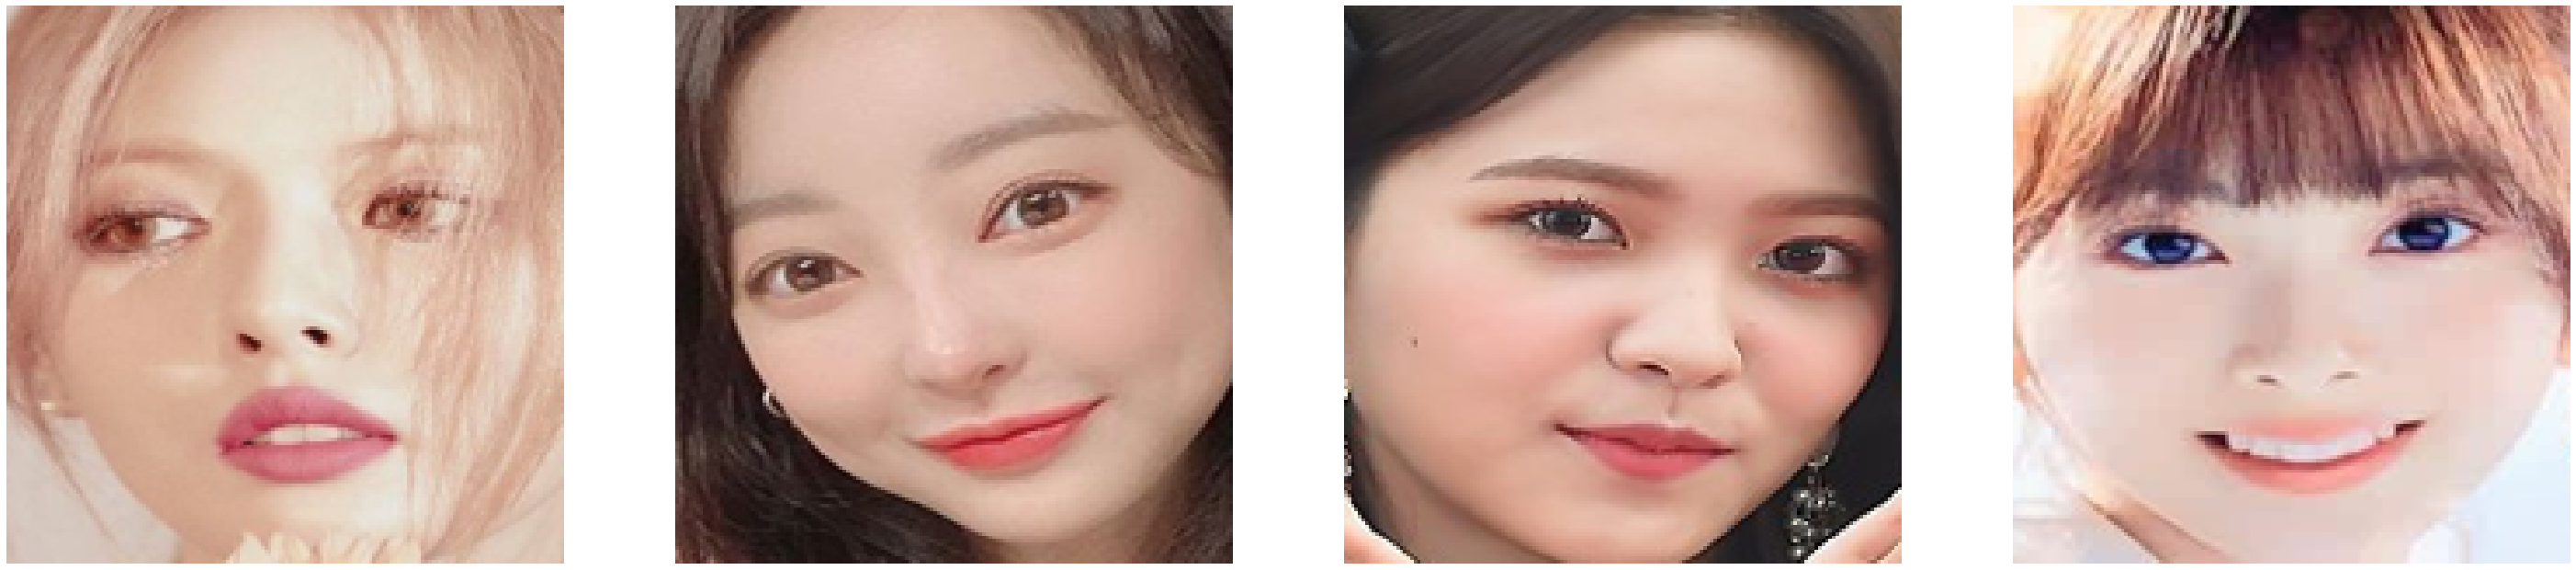

가장 선호하는 외모를 선택해 주세요. : 2


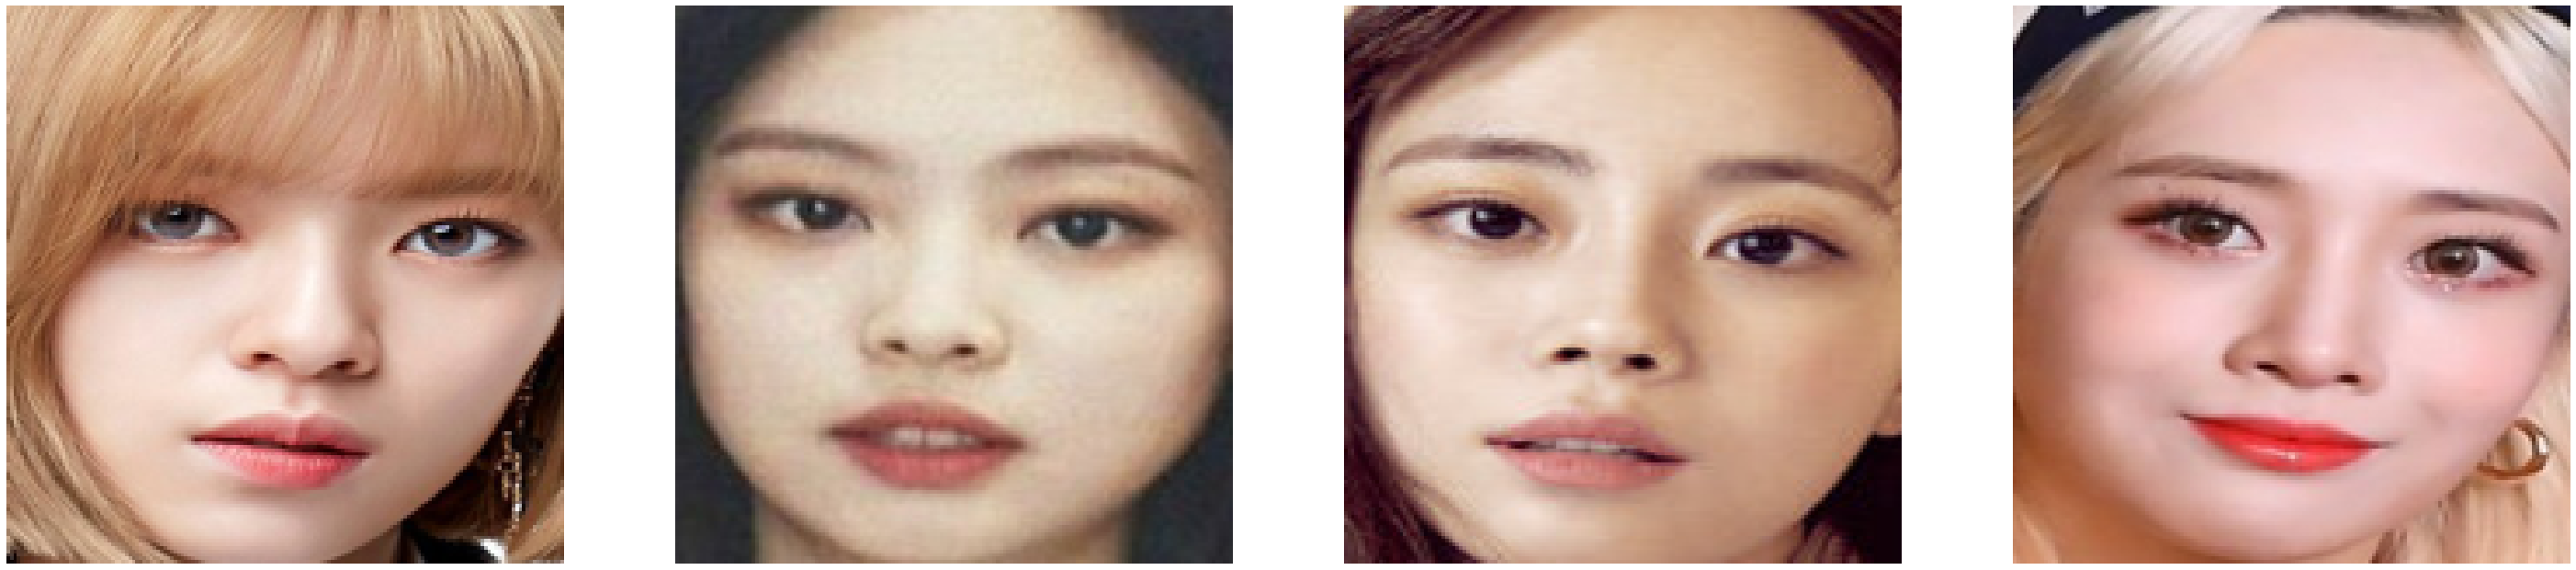

가장 선호하는 외모를 선택해 주세요. : 2
2


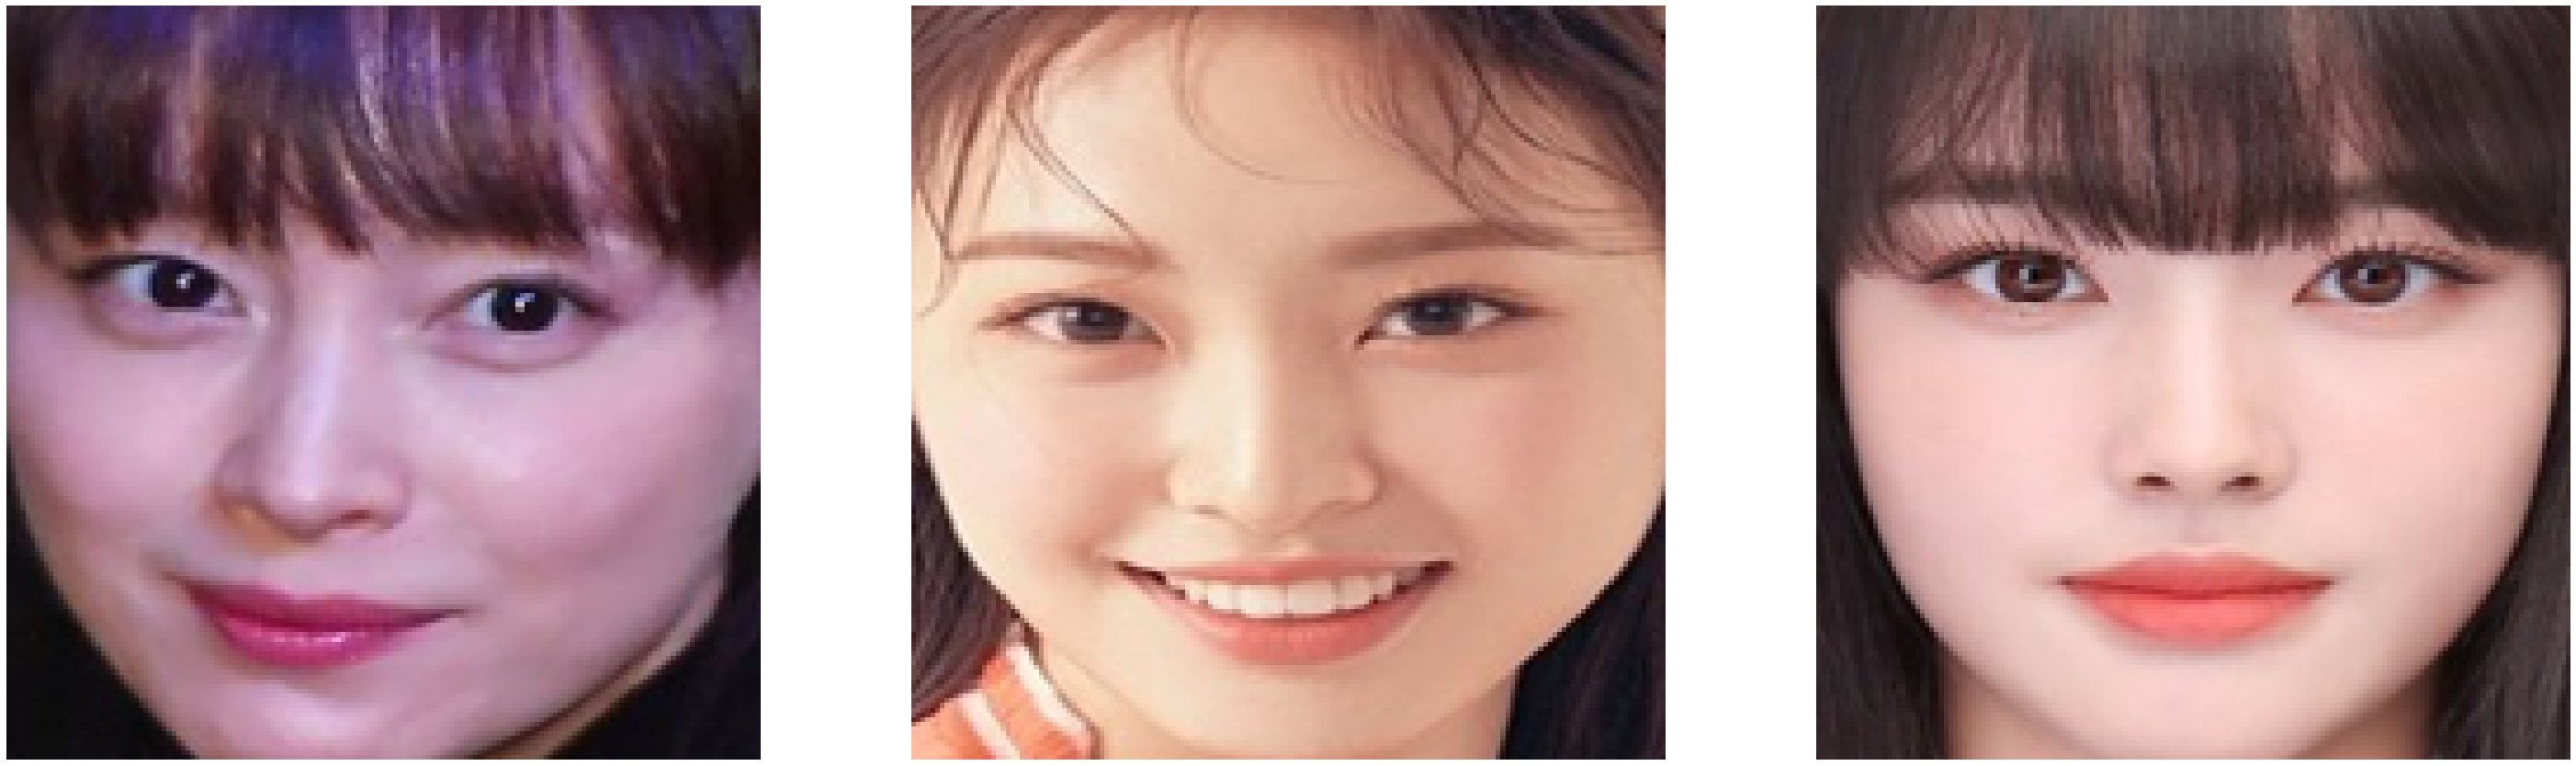

가장 선호하는 외모를 선택해 주세요. : 2


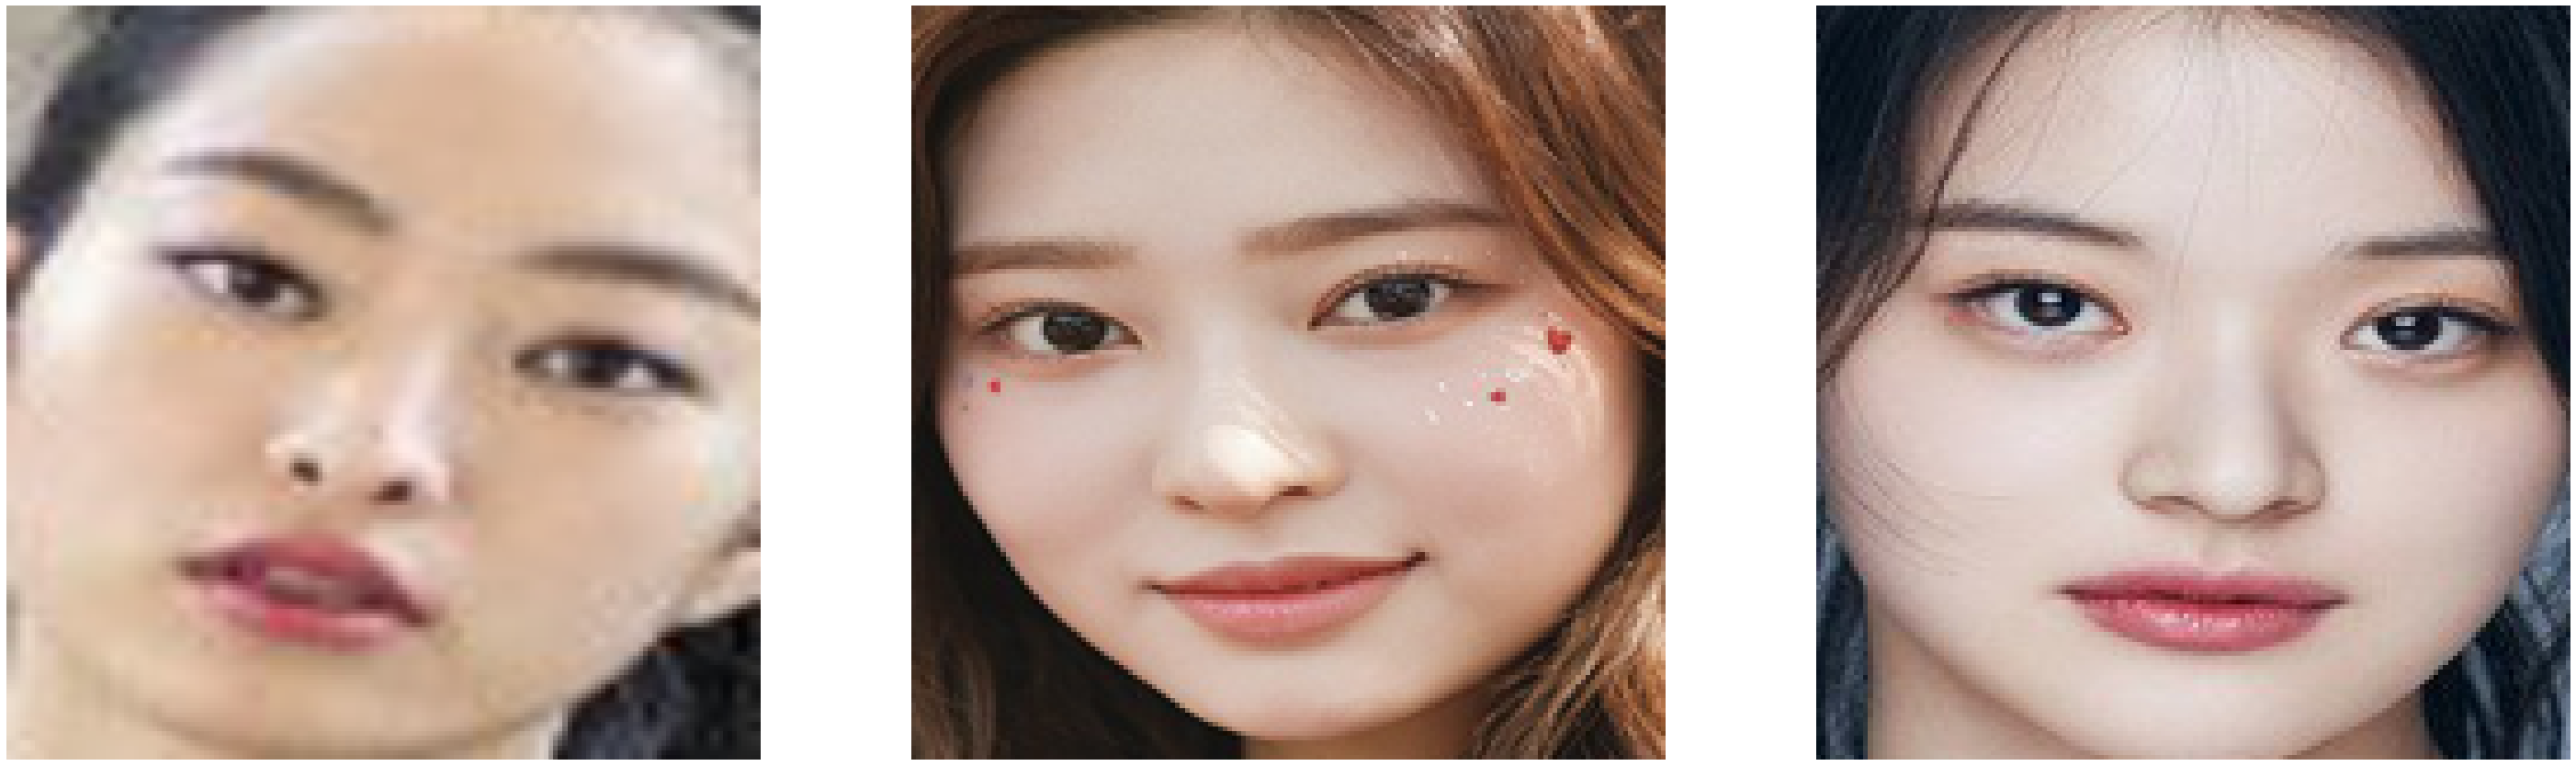

가장 선호하는 외모를 선택해 주세요. : 2


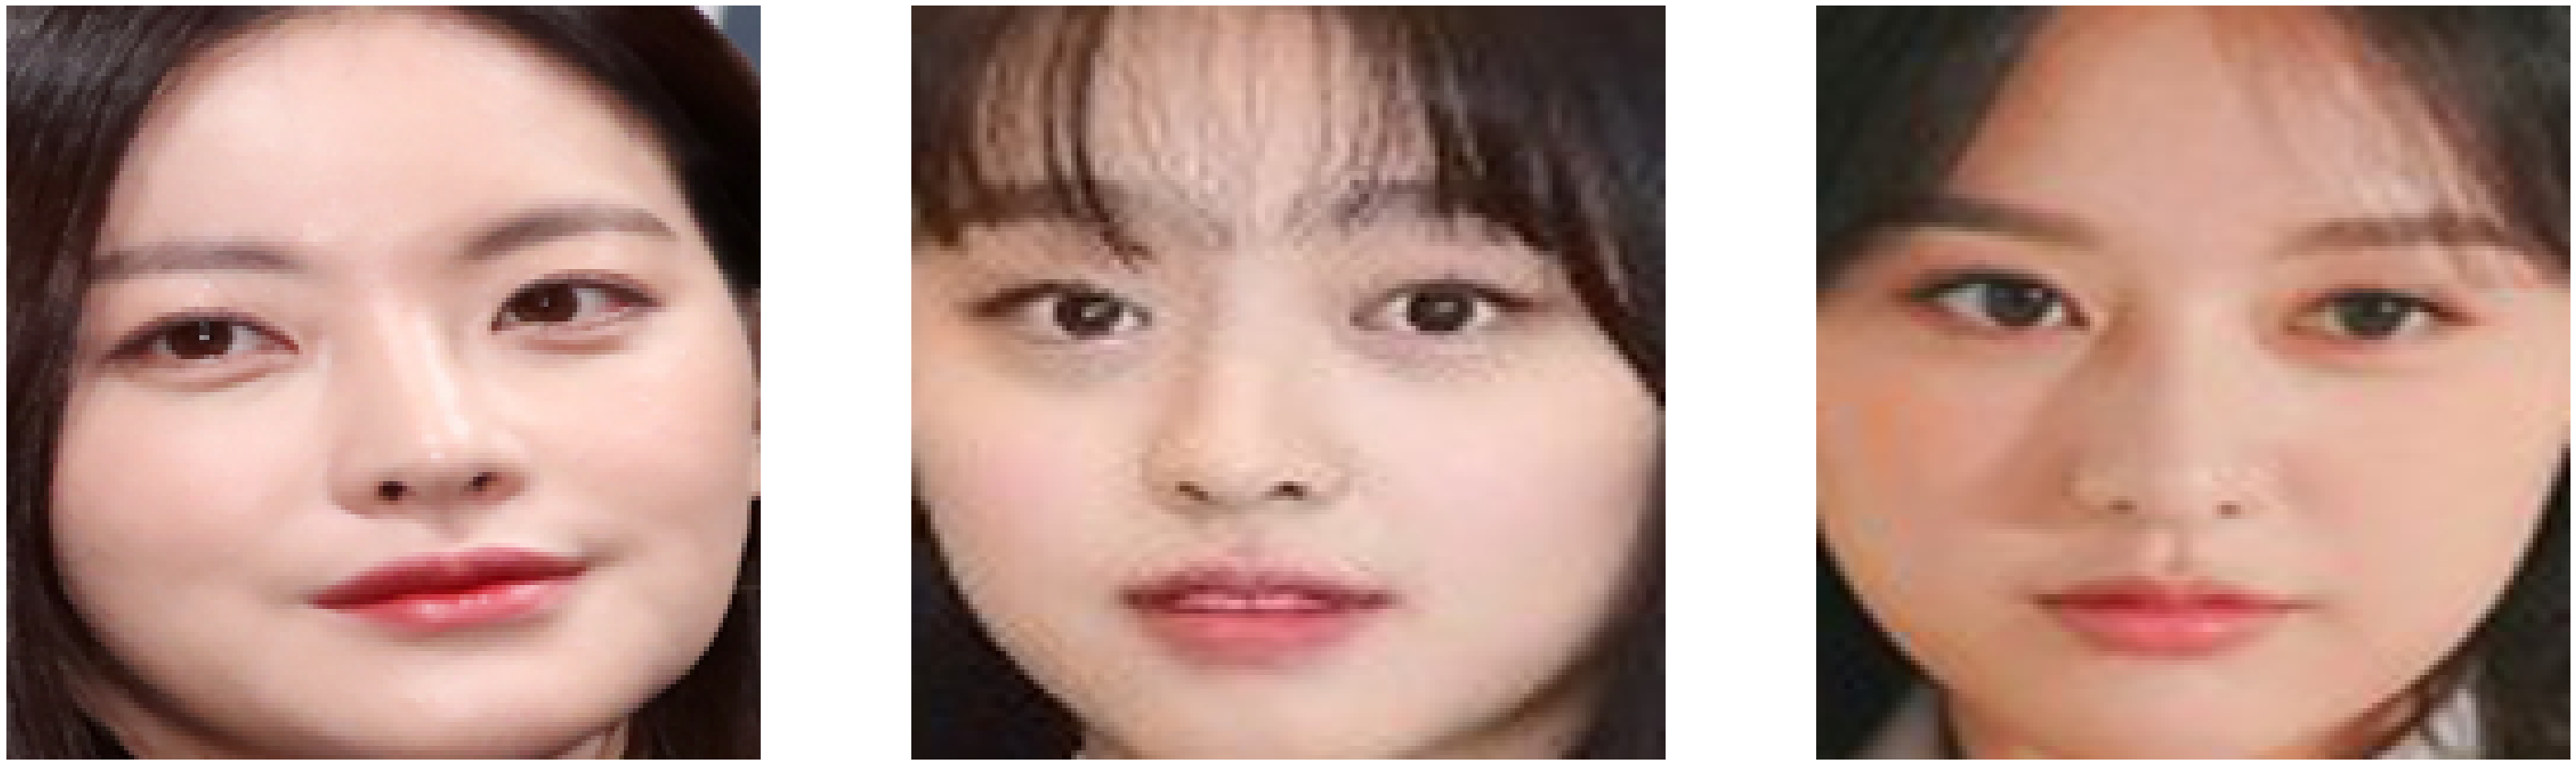

가장 선호하는 외모를 선택해 주세요. : 2


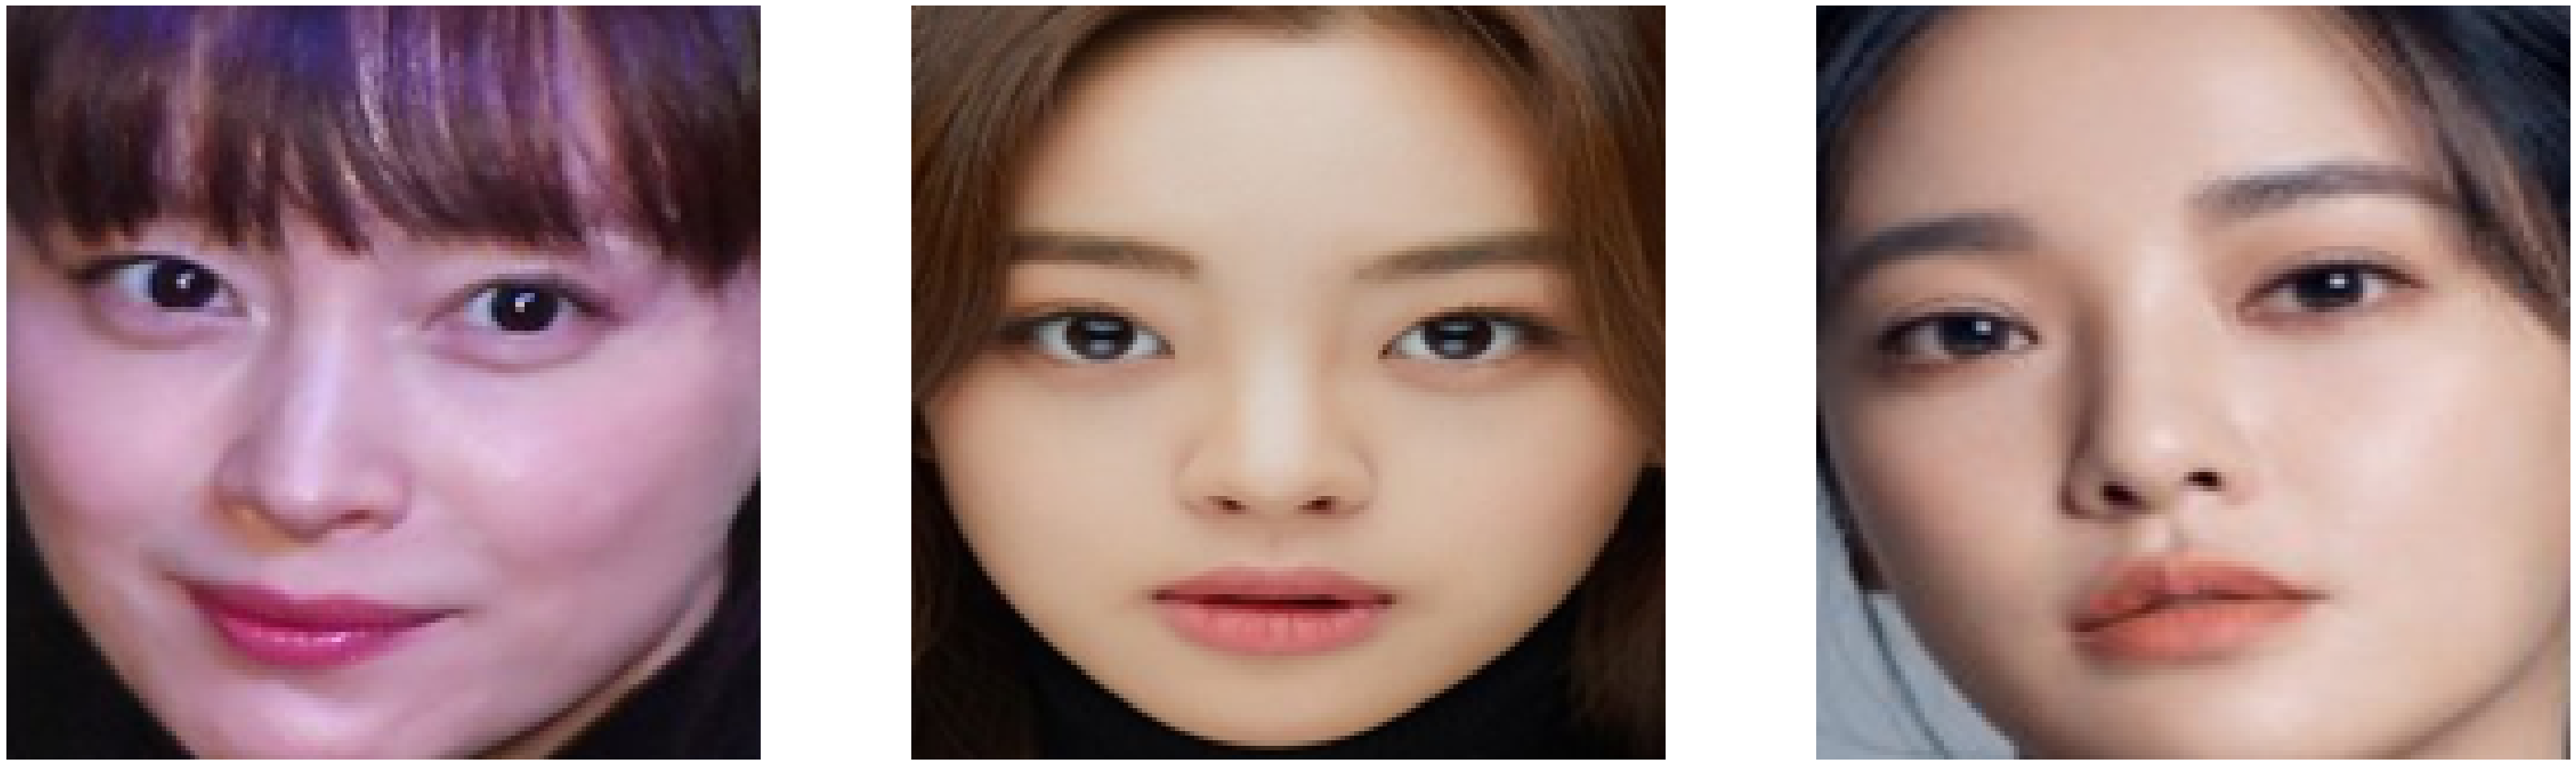

가장 선호하는 외모를 선택해 주세요. : 2


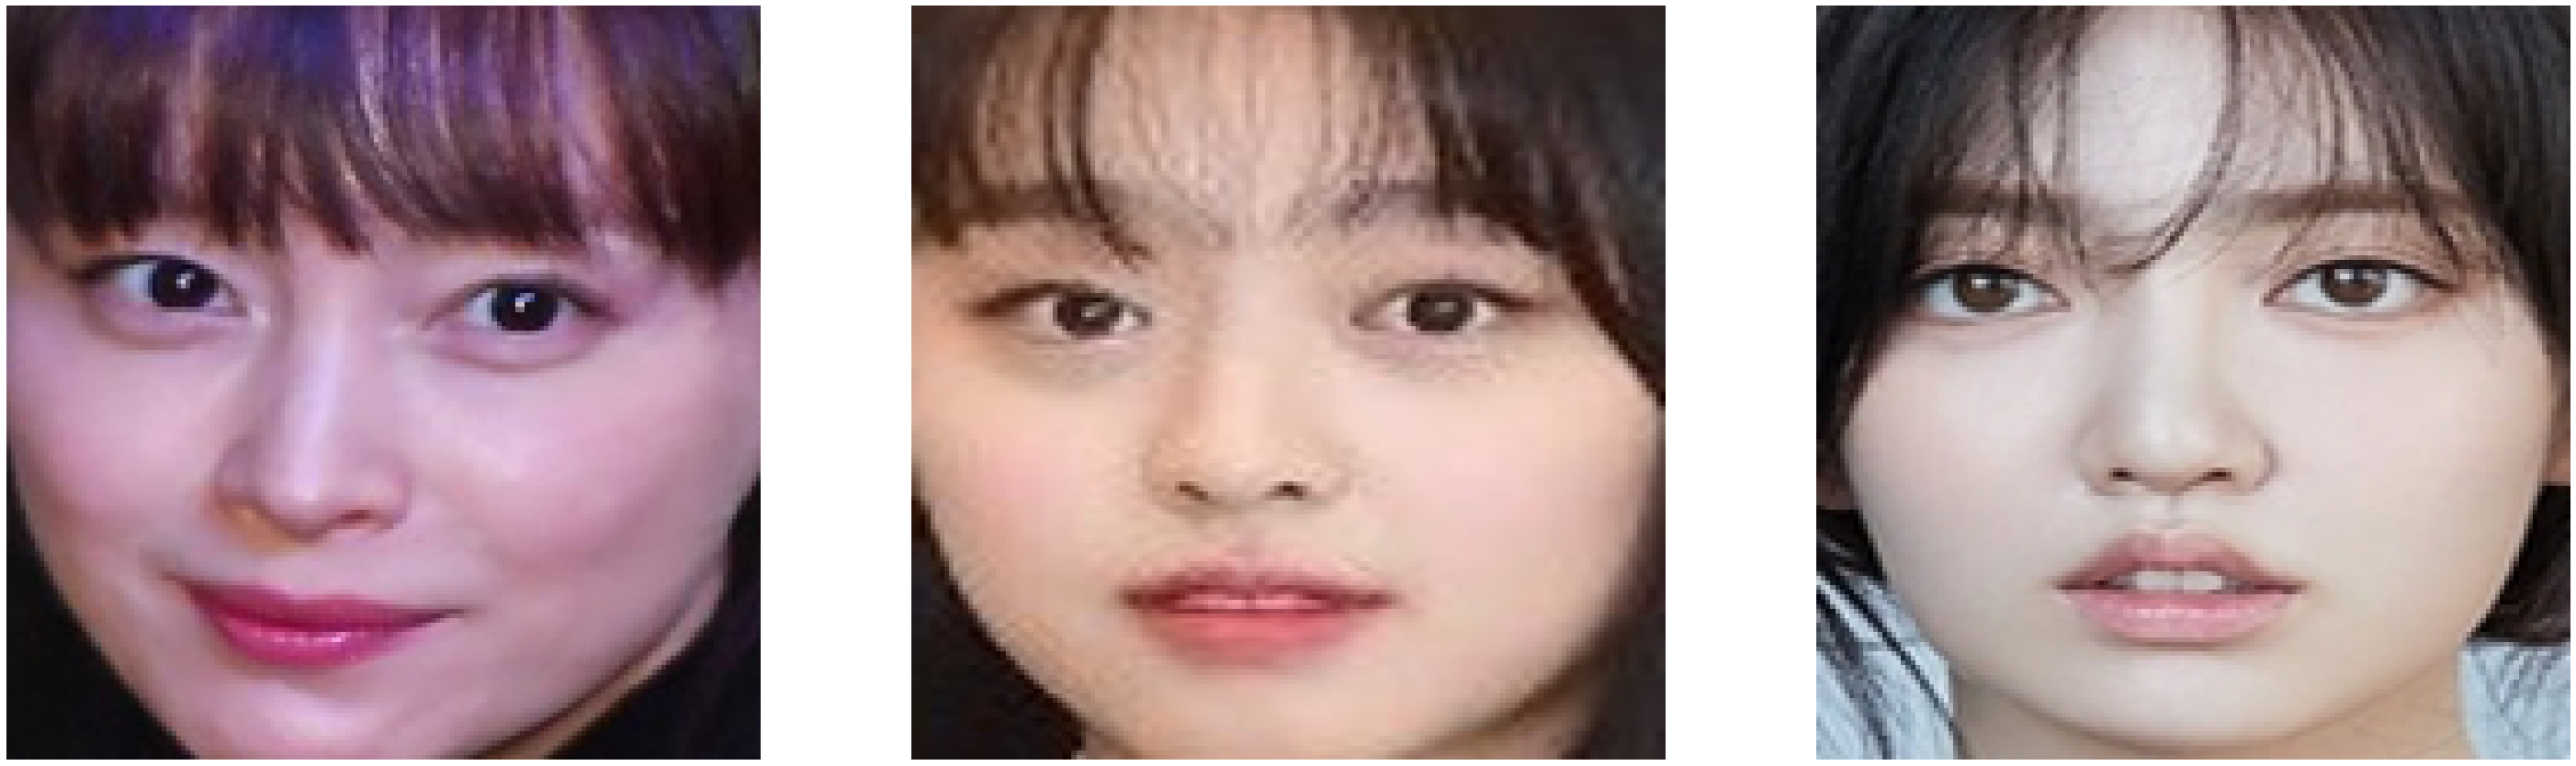

가장 선호하는 외모를 선택해 주세요. : 2


In [31]:
# for i in df.columns로 넣어도 될 듯? (업데이트 예정)

def Knock_out_stage_iter(data, arr, df):
  col = 0
  for i in [5,4,3]:
    print(col)
    ch = [] #실제로 사용자가 선택한 선택지들입니다.
    for k in range(5): #총 다섯 번의 선택지를 주어줍니다.
      ch_samples = [] #선택지로 보여줄 샘플들
      for j in range(i):
        ch_samples.append(df[df.iloc[:,col]==j].iloc[:,col].sample(1).index[0])
      fig = plt.figure(figsize=(50,50))
      p_idx = 1
      for j in ch_samples:
        fig.add_subplot(1, i, p_idx)
        plt.axis('off')
        plt.imshow(data[j])
        p_idx+=1
      plt.show()
      plt.pause(1)
      plt.close(fig)  
      ch.append(int(input('가장 선호하는 외모를 선택해 주세요. : '))-1)
    df = df[df.iloc[:,col]==max(ch, key=ch.count)]
    col+=1
  return df
    

final_df = Knock_out_stage_iter(female_data, female_embeddings, k_lb)

In [41]:
final_df

5  4  3
51   1  1  1
93   1  1  1
209  1  1  1
399  1  1  1
433  1  1  1
474  1  1  1
495  1  1  1
498  1  1  1
541  1  1  1
601  1  1  1

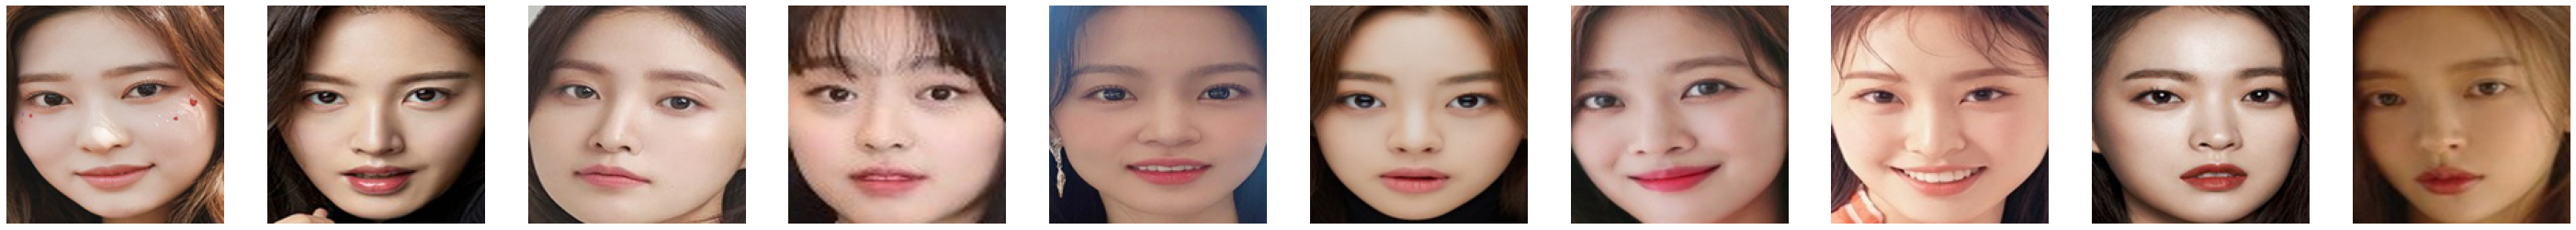

In [40]:
fig = plt.figure(figsize=(50,50))
p_idx = 1
for j in final_df.index:
  fig.add_subplot(1, len(final_df.index), p_idx)
  plt.axis('off')
  plt.imshow(female_data[j])
  p_idx+=1
plt.show()
plt.pause(1)
plt.close(fig)  